# 1
Построить распределение плотности вероятности для p-value, в случаях если $H_0$ верна и не верна для следующих случаев

### 1.1

Одновыборочный t-test $x_1 , \dots, x_n \in \mathcal{N}(\mu, 1)$ для проверки нулевой гипотезы $H_0: \mu_0 = 0$ против $H_1: \mu_0 > 0$. Для $\mu = 0, \mu = 0.5, \mu = 1$

Тестирование провести в случае $n = 4$


In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
from mlxtend.evaluate import permutation_test
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.descriptivestats import sign_test
from tqdm import tqdm_notebook
import warnings
import time
warnings.filterwarnings("ignore")

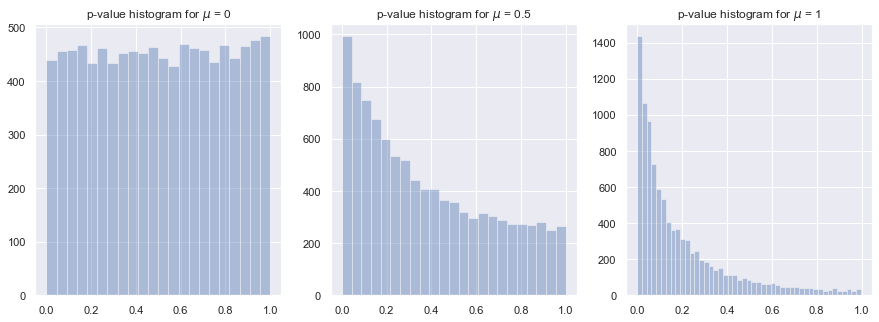

In [166]:
sns.set(style='darkgrid')
f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set(style='darkgrid')
sigma = 1
n = 4
mu_0 = 0
exp_num = 10000
mus = [0, 0.5, 1]
for k in range(3):
    p_values = []
    mu = mus[k]
    for i in range(exp_num):
        sample = np.random.normal(mu, sigma, n)
        _, p_val = scipy.stats.ttest_1samp(sample, mu_0)
        p_values.append(p_val)
    sns.distplot(p_values, ax=axes[k], kde=False)
    axes[k].set_title('p-value histogram for $\mu$ = ' + str(mus[k]))

Видим, что когда $\mu = \mu_0$, распределение p-value равномерное, а чем дальше $\mu$ от $H_0$, тем ближе гистограма у нуля

### 1.2

Одновыборочный t-test $x_1 , \dots, x_n \in \exp(1)$ для проверки нулевой гипотезы $H_0: \mu_0 = 0$ против $H_1: \mu_0 > 0$. Для $\mu = 0, \mu = 0.5, \mu = 1$

Тестирование провести в случае $n = 4$


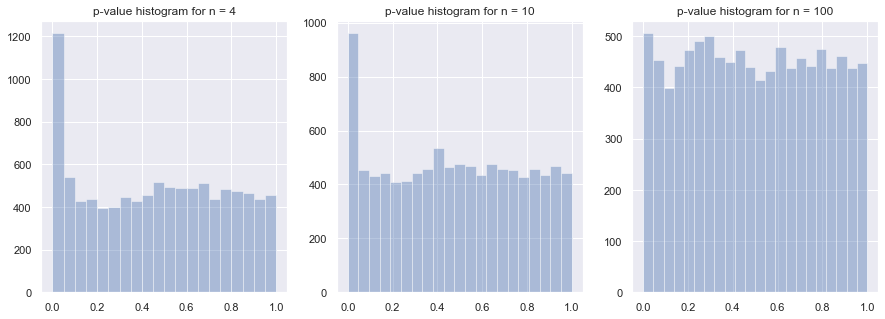

In [34]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set(style='darkgrid')
ns = [4, 10, 100]
lambda_0 = 1
exp_num = 10000
for k in range(3):
    p_values = []
    n = ns[k]
    for i in range(exp_num):
        sample = np.random.exponential(lambda_0, n)
        _, p_val = scipy.stats.ttest_1samp(sample, lambda_0)
        p_values.append(p_val)
    sns.distplot(p_values, ax=axes[k], kde=False)
    axes[k].set_title('p-value histogram for n = ' + str(ns[k]))

Для маленьких n предположение о том, что t-статистика имеет распределение Стьюдента неверно, поэтому для верной $\lambda_0$ p-value все равно не распределено равномерно, для больших n (> 40) t-статистика имеет нормальное распределение, а значит и распределение Стьюдента (ведь для большого количества степеней свободы они очень похожи)
и p-value распределено примерно равномерно

# 2

Есть два алгоритма машинного обучения, качества которых задаются случайным величинами $X_1, X_2$. Алгоритмы называются неразличимыми по качеству, если  $\delta \mu = \mu_1 - \mu_2 = E X_1 - E X_2 = 0$

Будем сравнивать качество алгоритмов аппаратом проверки статистических гипотез: $H_0: \Delta \mu = 0$ и $H_1: \Delta \mu \neq 0$ по выборкам $(x_1^1, \dots, x_n^1), \ (x_1^2, \dots, x_n^2)$

Рассматриваем критерии: Стьюдента, Вальда, Манна-Уитни-Уилкоксона, знаков и перестановок

$X_1$ и $X_2$ берем из стандартного нормального распределения, логнормального распределения, распределения Коши на [-3, 3]

Для всех распределений $\mu = 0, \sigma = 1$, для различных распределений $\sigma_1 = 2\sigma_2$

Все эксперименты производятся моделированием Монте-Карло с числом повторений $N_r = 10^3$ и размером выборки $N_s \in \{1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100\}$

$\alpha = 0.05$, $\Delta \mu$ от 0 до 3 с шагом 0.1



Функция распределения Коши обратима: $F^{-1}(x) = x_0 + \gamma tg\left(\pi(x - 0.5)\right)$, тогда чтобы генерировать выборку из распределения Коши, можно брать выборку из Uniform[0, 1] и брать обратную функцию. Т.к. нам нужно Коши из [-3, 3], будем генерить Uniform[0.102, 0.898]

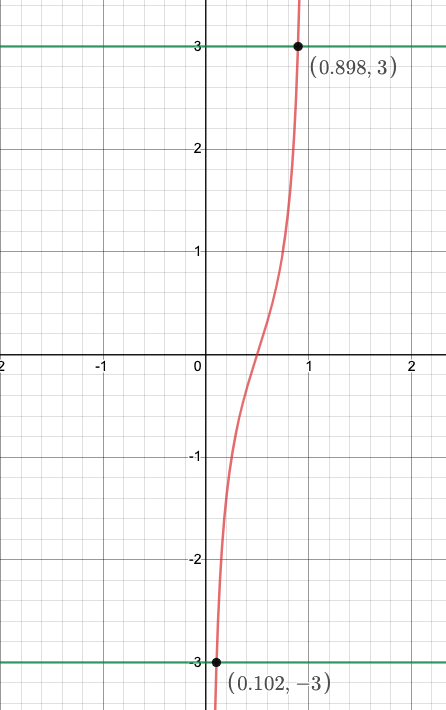

In [108]:
def get_lognorm_params(mu, sigma):
    ln_var = scipy.stats.lognorm.var(s=1, loc=-mu)
    ln_mean = scipy.stats.lognorm.mean(s=1, loc=-mu, scale=np.sqrt(sigma) / np.sqrt(ln_var))       
    return [-ln_mean, np.sqrt(sigma) / np.sqrt(ln_var)]

def get_cauchy(x, x_0=0, gamma=1):
    return x_0 + gamma * np.tan(np.pi*(x-0.5))

def tests(X_1, X_2):
        pvals = np.zeros(5)
        _, pvals[0] = ttest_ind(X_1, X_2)
        _, pvals[1] = ztest(X_1, X_2)
        _, pvals[2] = mannwhitneyu(X_1, X_2, alternative='two-sided')
        _, pvals[3] = sign_test(X_1 - X_2, 0)
        pvals[4] = permutation_test(X_1, X_2, method='approximate', num_rounds=50)
        return pvals
    
def plot(ax, err, title):
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_xlabel('sample size')
    ax.set_ylabel('$\\alpha $')
    ax.plot(sample_ns, [0.05] * len(sample_ns), linestyle='dashed', label ='alpha')
    ax.plot(sample_ns, err[::5], label='t-test')
    ax.plot(sample_ns, err[1::5], label='z-test')
    ax.plot(sample_ns, err[2::5], label='mww')
    ax.plot(sample_ns, err[3::5], label='sign test')
    ax.plot(sample_ns, err[4::5], label='permutations test')
    ax.legend()

In [66]:
def plot_alpha(params, order, title):
    f, axes = plt.subplots(1, 3, figsize=(17, 5))
    f.suptitle(title, fontsize='x-large')
    norm, lognorm, cauchy = np.array([]),  np.array([]),  np.array([])
    norm_p1, norm_p2, lognorm_p1, lognorm_p2, cauchy_p1, cauchy_p2 = params
    for i in tqdm_notebook(range(len(sample_ns))):
        n = sample_ns[i]
        errors_norm, errors_lognorm, errors_cauchy = np.zeros(5), np.zeros(5), np.zeros(5)
        for i in range(montecarlo_n):
            samples = []
            samples.append(scipy.stats.norm.rvs(norm_p1[0], norm_p1[1], n))
            samples.append(scipy.stats.norm.rvs(norm_p2[0], norm_p2[1], n))
            samples.append(scipy.stats.lognorm.rvs(1, lognorm_p1[0], lognorm_p1[1], n))
            samples.append(scipy.stats.lognorm.rvs(1, lognorm_p2[0], lognorm_p2[1], n))
            samples.append(get_cauchy(scipy.stats.uniform.rvs(a_0, b_0 - a_0, n), x_0=cauchy_p1[0], gamma=cauchy_p1[1]))
            samples.append(get_cauchy(scipy.stats.uniform.rvs(a_0, b_0 - a_0, n), x_0=cauchy_p2[0], gamma=cauchy_p2[1]))
            errors_norm += tests(samples[order[0]], samples[order[1]]) < alpha
            errors_lognorm += tests(samples[order[2]], samples[order[3]]) < alpha
            errors_cauchy += tests(samples[order[4]], samples[order[5]]) < alpha
        errors_norm /= montecarlo_n
        errors_lognorm /= montecarlo_n
        errors_cauchy /= montecarlo_n
        norm = np.concatenate((norm, errors_norm))    
        lognorm = np.concatenate((lognorm, errors_lognorm))
        cauchy = np.concatenate((cauchy, errors_cauchy))
    plot(axes[0], norm, 'Normal')
    plot(axes[1], lognorm, 'Lognormal')
    plot(axes[2], cauchy, 'Cauchy')

## 2.1
### Строим количество ошибок первого рода:

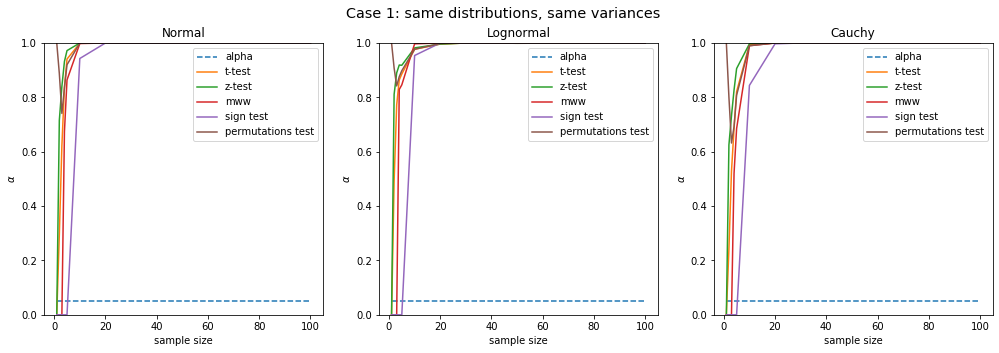

In [109]:
alpha = 0.05
mu_0, sigma_0 = 0, 1
a_0, b_0 = 0.102, 0.898
lognorm_mu_0, lognorm_sigma_0 = get_lognorm_params(mu_0, sigma_0)
sample_ns = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
montecarlo_n = 1000

plot_alpha([[mu_0, sigma_0], [mu, sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu, sigma_0]],
           list(range(6)), 'Case 1: same distributions, same variances')


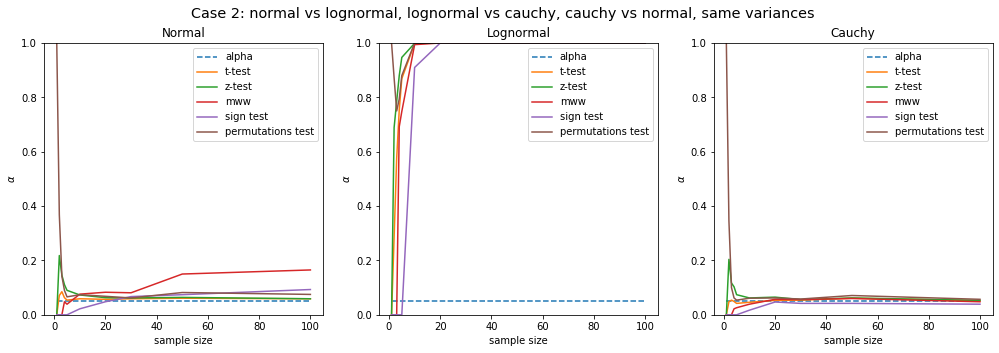

In [110]:
plot_alpha([[mu_0, sigma_0], [mu, sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu, sigma_0]], [0, 2, 3, 4, 5, 1], 
    'Case 2: normal vs lognormal, lognormal vs cauchy, cauchy vs normal, same variances')


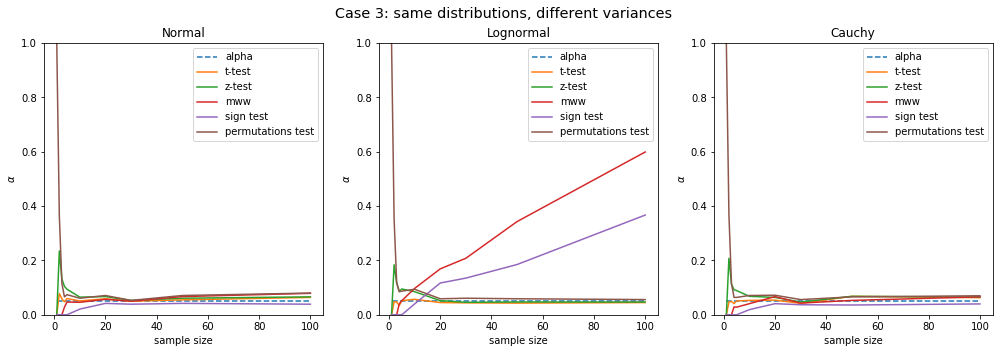

In [111]:
montecarlo_n = 1000
lognorm_mu_1, lognorm_sigma_1 = get_lognorm_params(mu_0, 2 * sigma_0)
plot_alpha([[mu_0, sigma_0], [mu_0, 2 * sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu_0, 2 * sigma_0]], list(range(6)), 
    'Case 3: same distributions, different variances')

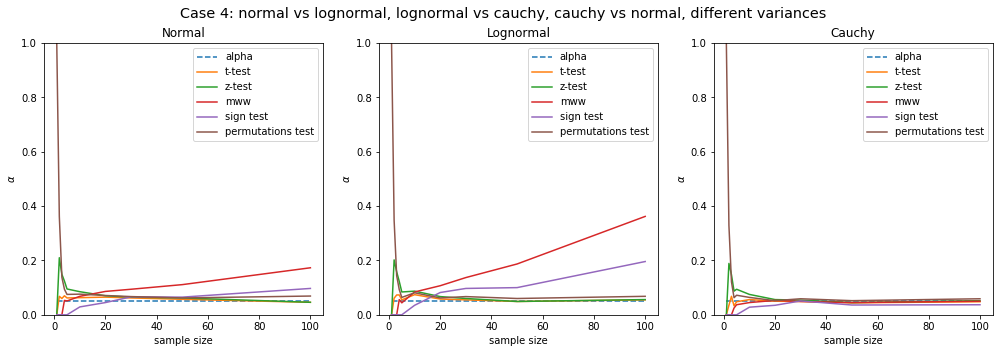

In [112]:

lognorm_mu_1, lognorm_sigma_1 = get_lognorm_params(mu_0, 2 * sigma_0)
plot_alpha([[mu_0, sigma_0], [mu_0, 2 * sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu_0, 2 * sigma_0]], [0, 2, 3, 4, 5, 1], 
    'Case 4: normal vs lognormal, lognormal vs cauchy, cauchy vs normal, different variances')

Видим, что для lognormal mww и sign test работают плохо

## 2.2
### Строим количество ошибок второго рода:

In [98]:
mus = np.arange(0, 3, 0.5)
print(mus)

[0.  0.5 1.  1.5 2.  2.5]


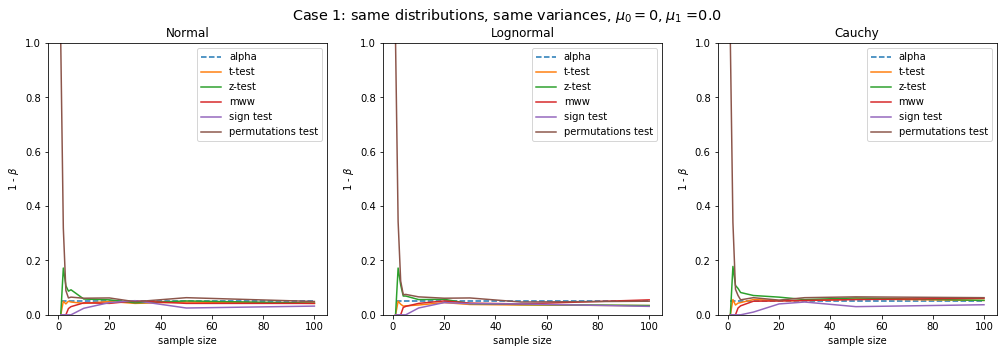

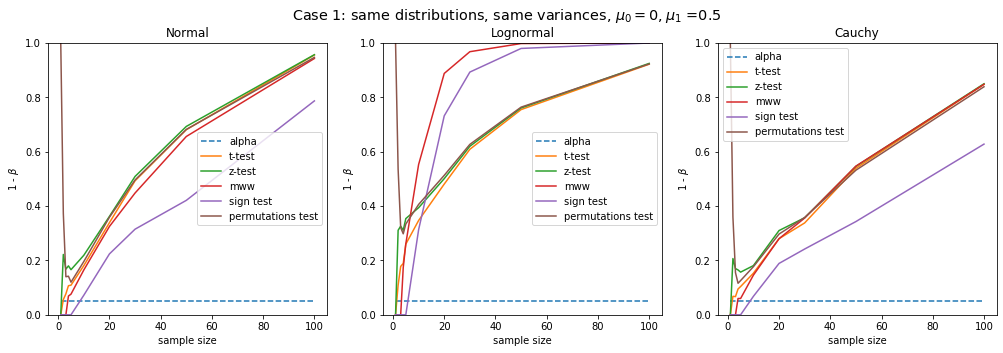

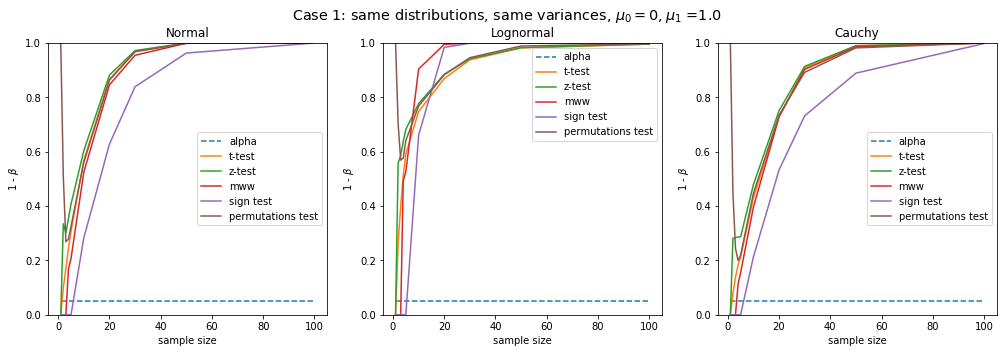

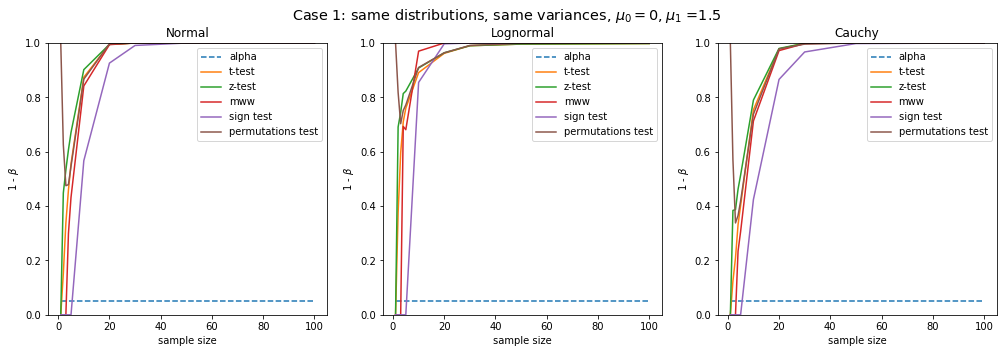

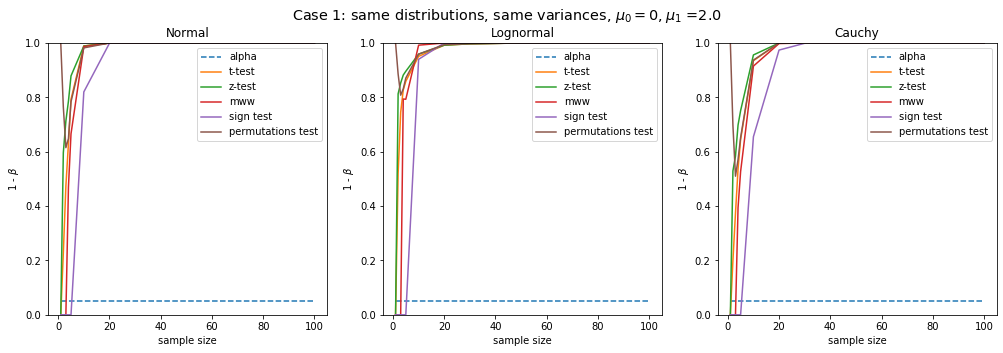

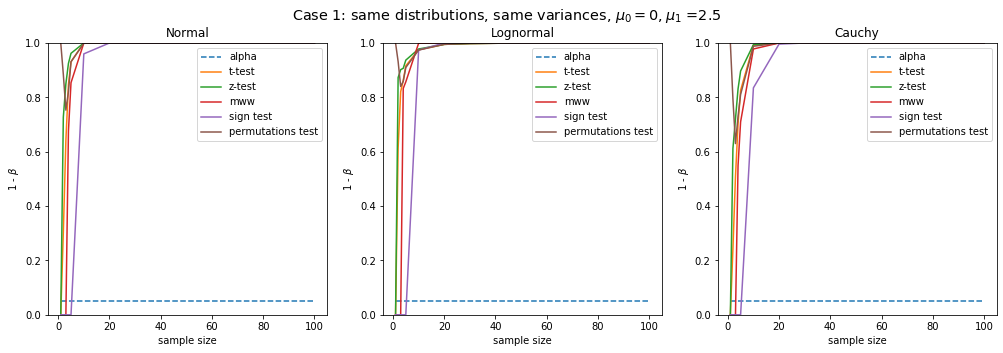

In [99]:
montecarlo_n = 1000
for i in tqdm_notebook(range(len(mus))):
    mu = mus[i]
    lognorm_mu_1, lognorm_sigma_1 = get_lognorm_params(mu, sigma_0)
    plot_alpha([[mu_0, sigma_0], [mu, sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu, sigma_0]],
            list(range(6)), 'Case 1: same distributions, same variances, $\mu_0 = {}, \mu_1$ ={}'.format(mu_0, mu))


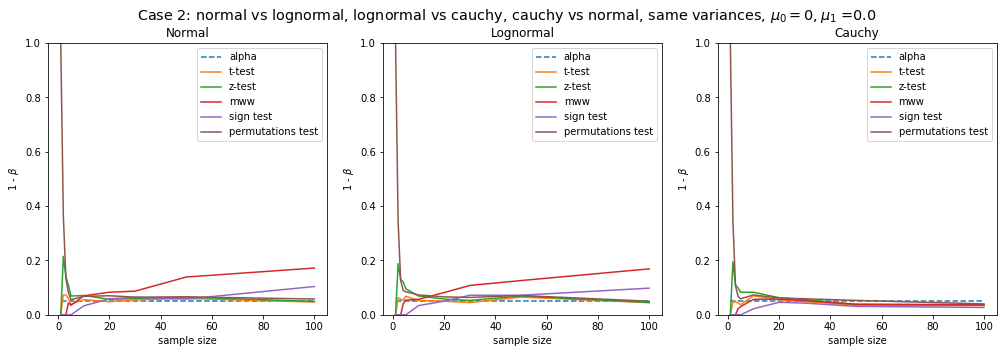

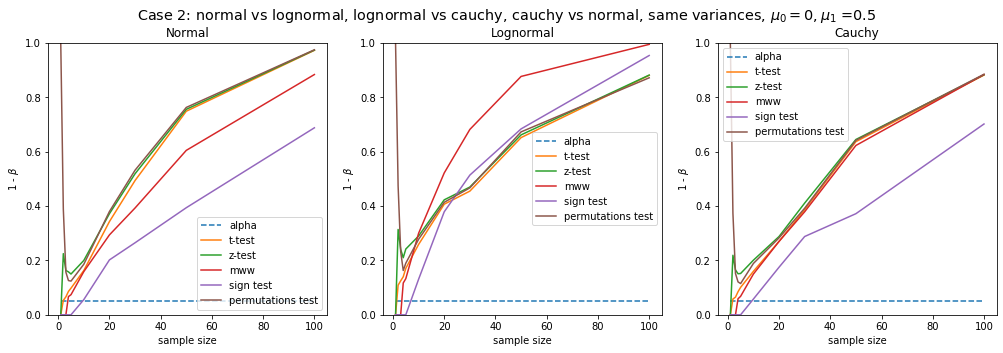

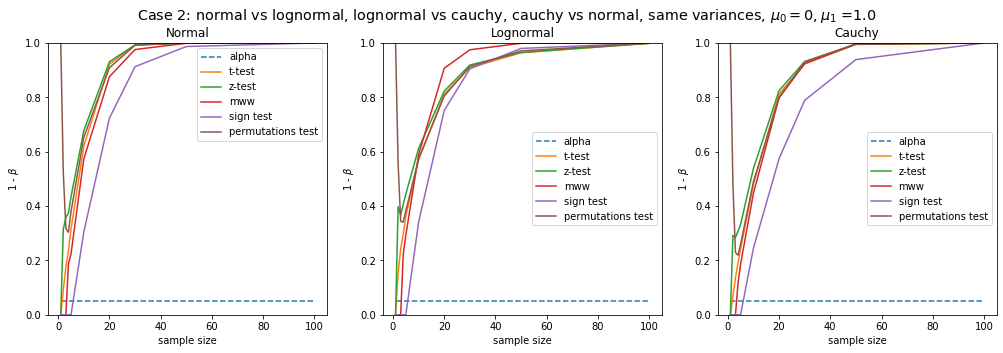

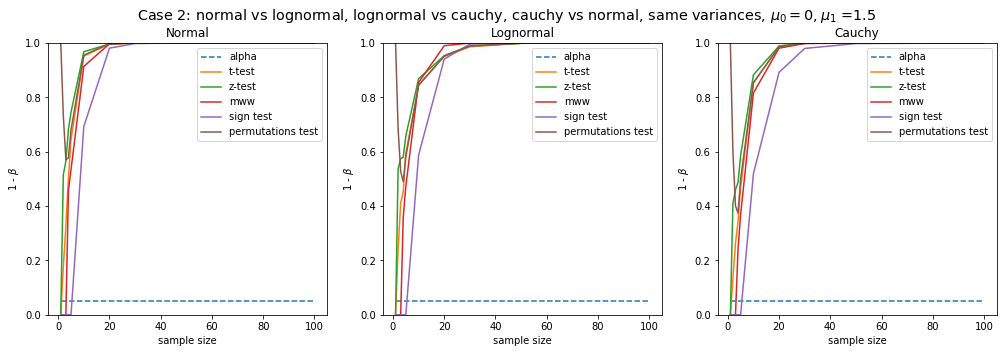

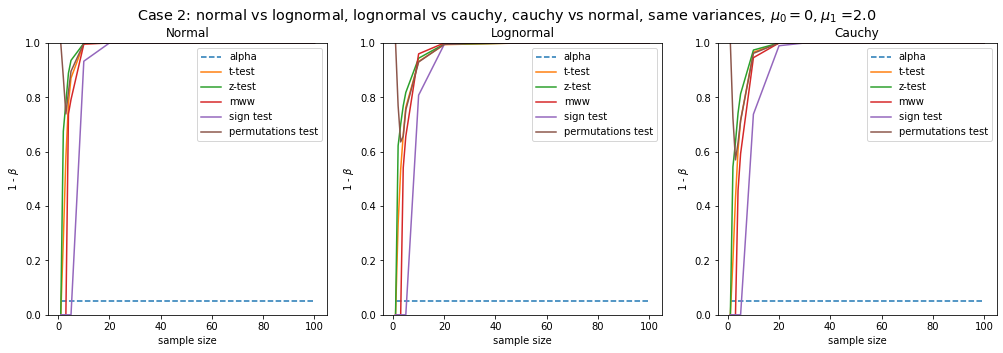

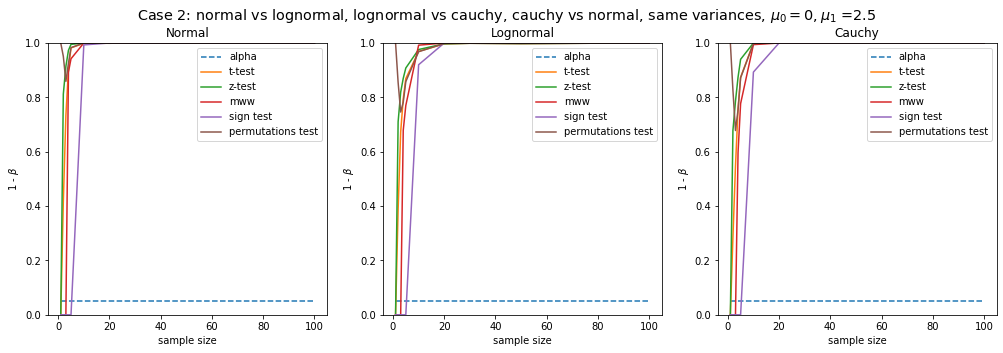

In [101]:
for i in tqdm_notebook(range(len(mus))):
    mu = mus[i]
    lognorm_mu_1, lognorm_sigma_1 = get_lognorm_params(mu, sigma_0)
    plot_alpha([[mu_0, sigma_0], [mu, sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu, sigma_0]],
            [0, 3, 2, 5, 4, 1], 
            'Case 2: normal vs lognormal, lognormal vs cauchy, cauchy vs normal, same variances, $\mu_0 = {}, \mu_1$ ={}'.format(mu_0, mu))


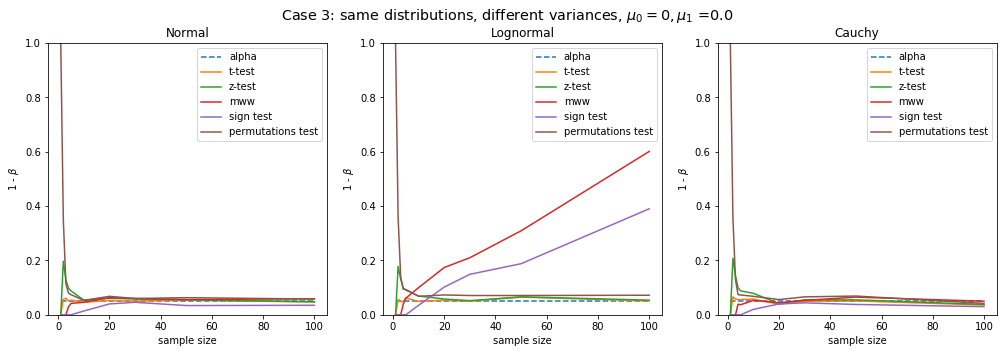

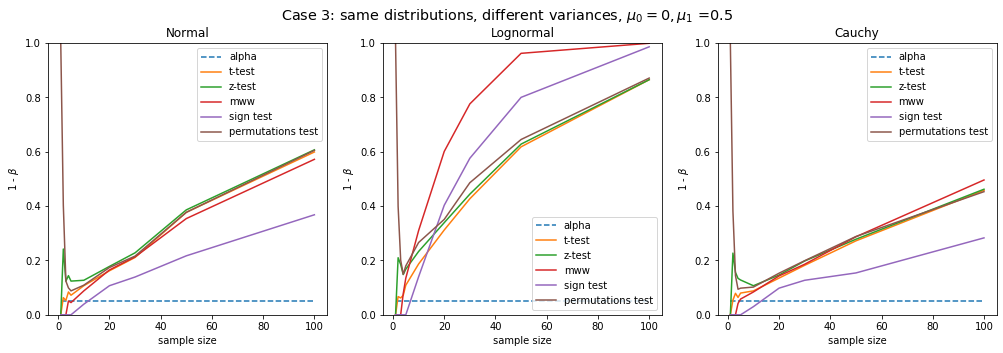

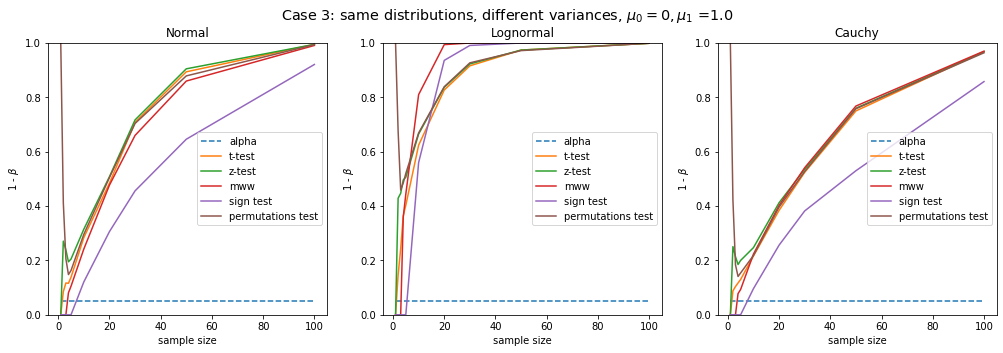

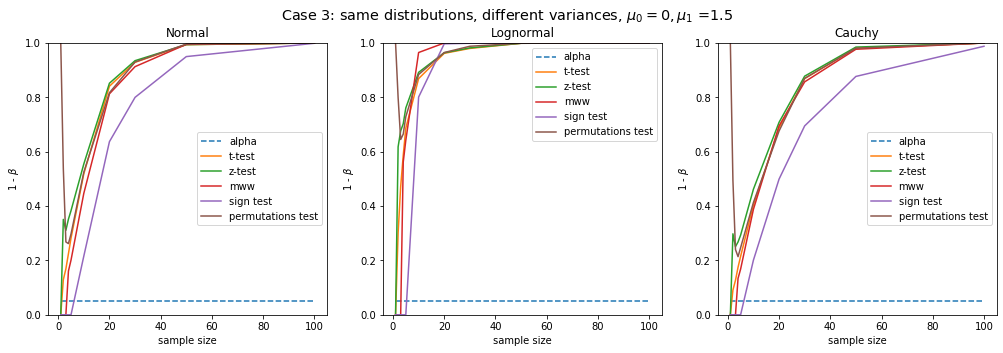

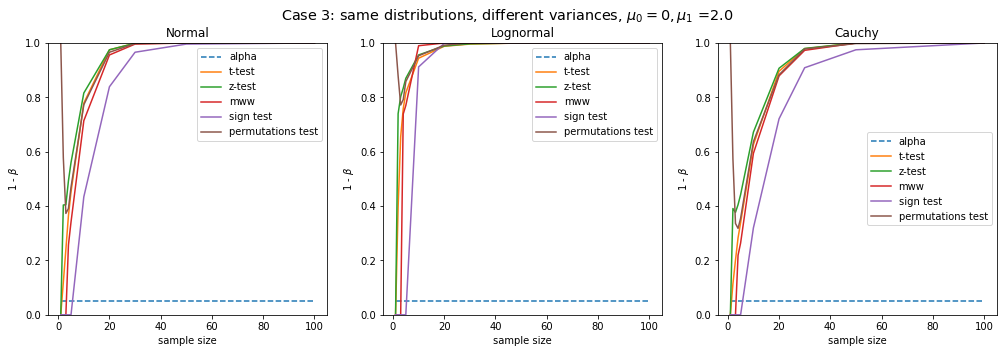

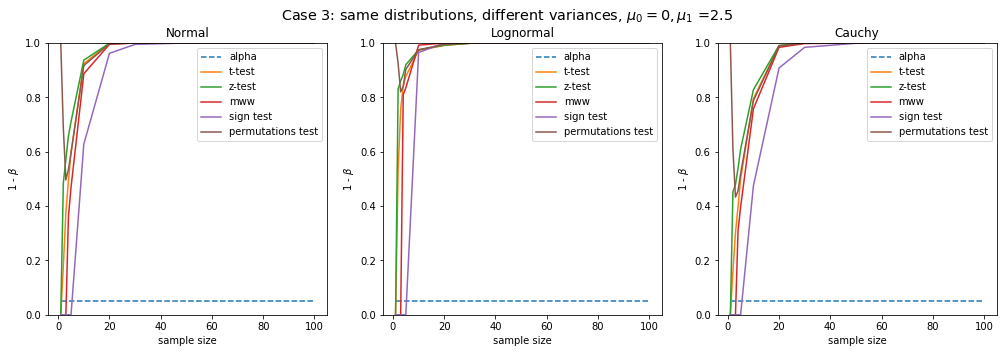

In [ ]:
for i in tqdm_notebook(range(len(mus))):
    mu = mus[i]
    lognorm_mu_1, lognorm_sigma_1 = get_lognorm_params(mu, 2 * sigma_0)
    plot_alpha([[mu_0, sigma_0], [mu, 2 * sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu, 2 * sigma_0]],
            list(range(6)), 
            'Case 3: same distributions, different variances, $\mu_0 = {}, \mu_1$ ={}'.format(mu_0, mu))


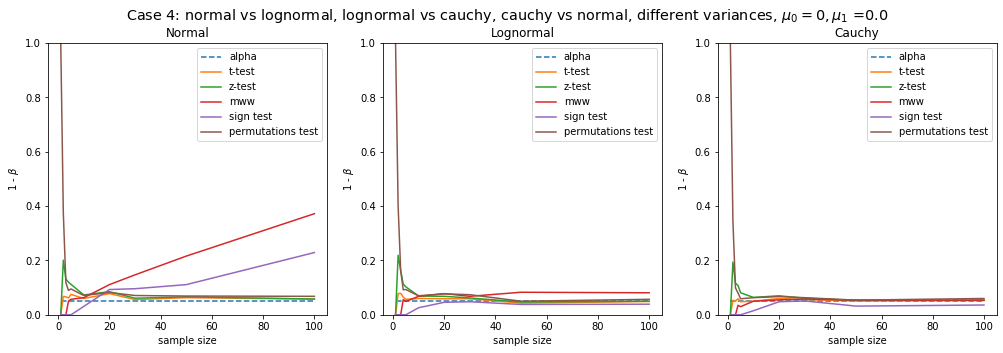

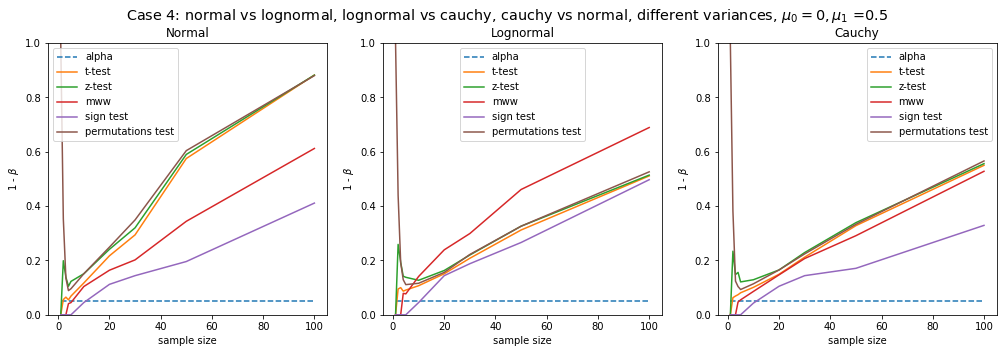

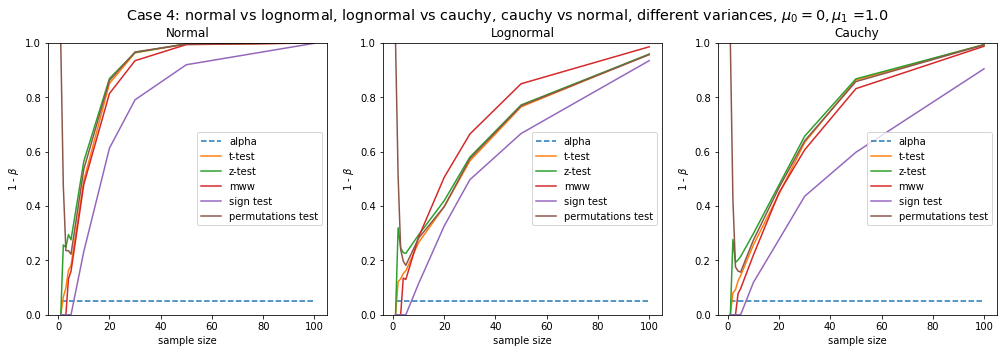

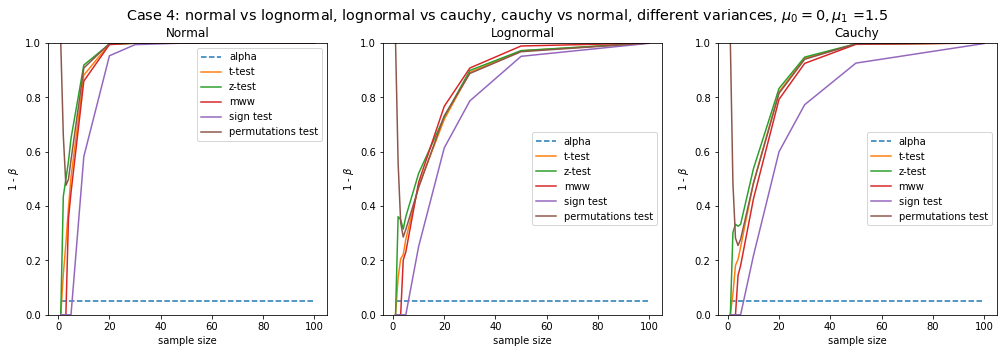

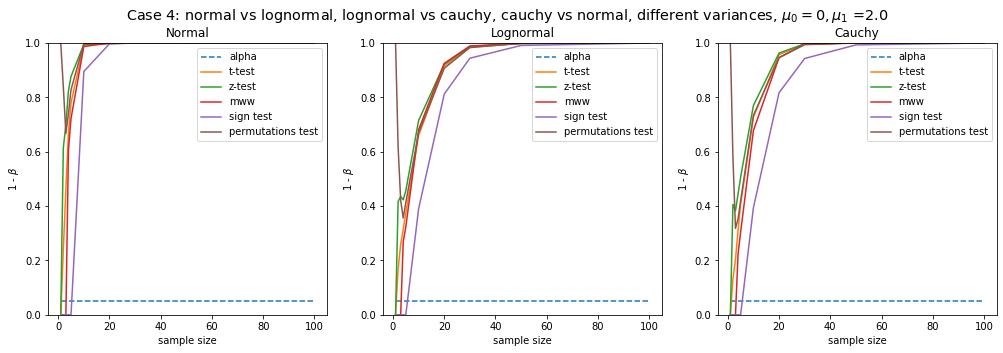

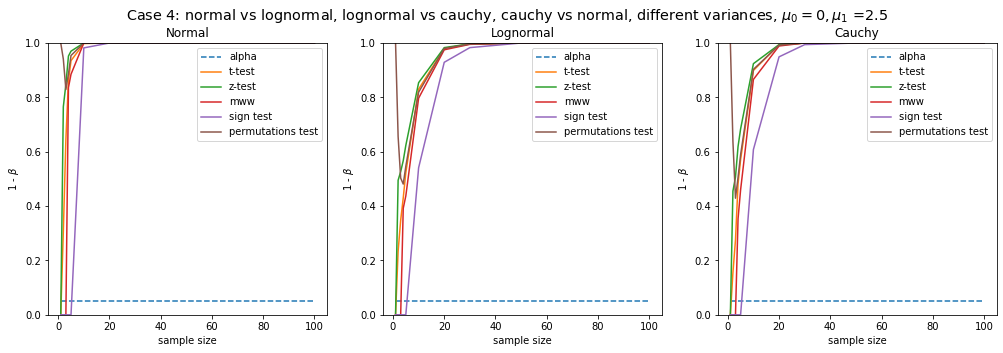

In [104]:
for i in tqdm_notebook(range(len(mus))):
    mu = mus[i]
    lognorm_mu_1, lognorm_sigma_1 = get_lognorm_params(mu, 2 * sigma_0)
    plot_alpha([[mu_0, sigma_0], [mu, 2 * sigma_0], 
            [lognorm_mu_0, lognorm_sigma_0], [lognorm_mu_1, lognorm_sigma_1],
            [mu_0, sigma_0], [mu, 2 * sigma_0]],
            [0, 3, 2, 5, 4, 1],
            'Case 4: normal vs lognormal, lognormal vs cauchy, cauchy vs normal, different variances, $\mu_0 = {}, \mu_1$ ={}'.format(mu_0, mu))


# 3

У нас есть датасет с координатами падения бомб на Лондон во время WW2

Хотим придумать тест для различия гипотез: $H_0: $бомбы падали равномерно на плоскости vs $H_1:$ бомбы падали неравномерно

## 3.1

Реализуйте и примените тест для $\alpha = 0.05$

Для проверки гипотезы $H_0:$ координаты бомб взяты из равномерного распределения, воспользуюсь хи-квадрат критерием Пирсона

Для этого сначала почищу данные и разобью оставшуюся площадь на 4 бина (именно столько районов нас интересует исходя из картинки в задании)

In [113]:
coords_df = pd.read_csv("/Users/arinaruck/Downloads/v2_bombing_london.csv")
coords_df.head()

Unnamed: 0                            Name  \
0           0                  New Cross Road   
1           1  Hughes Mansions, Vallance Road   
2           2               Smithfield Market   
3           3                  Mackenzie Road   
4           4                  Trundleys Road   

                                         Description         x          y  
0  <img src="https://lh6.googleusercontent.com/pr... -0.038903  51.475529  
1  March 27, 1945, 134 Dead. Final V2 to hit London. -0.063665  51.521308  
2  March 8 1945, 110 Dead<br><br>Comment from Mar... -0.104971  51.518978  
3  December 26, 1944, 68 Dead. Prince of Wales pu... -0.112395  51.549057  
4                            March 7, 1945, 53 Dead. -0.041606  51.484055

In [114]:
from ipyleaflet import Map, Circle, LayerGroup, Polyline, basemaps 

def show_circles_on_map(data, latitude_column, longitude_column, color):

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.8,
            radius=150,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)
    
    lat_q_5 = data[latitude_column].quantile(q=0.07)
    lat_q_95 = data[latitude_column].quantile(q=0.87)
    lon_q_5 = data[longitude_column].quantile(q=0.07)
    lon_q_95 = data[longitude_column].quantile(q=0.87)
    
    new_data = data.loc[data[longitude_column] < lon_q_95].loc[data[longitude_column] > lon_q_5].\
                loc[data[latitude_column] < lat_q_95].loc[data[latitude_column] > lat_q_5]
    
    print(len(new_data.index))
    circles = []
    for _, row in new_data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color='yellow',
            fill_opacity=0.95,
            radius=100,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)
    
    return result_map

show_circles_on_map(coords_df, 'y', 'x', 'blue')

219


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

Вспомнила, что виджеты не грузит, поэтому дублирую все карты

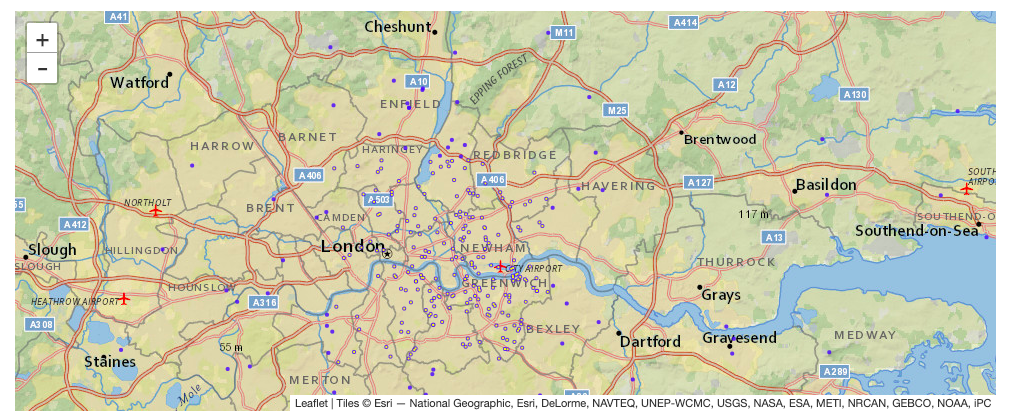

In [115]:
lat_q_5 = coords_df['y'].quantile(q=0.07)
lat_q_95 = coords_df['y'].quantile(q=0.87)
lon_q_5 = coords_df['x'].quantile(q=0.07)
lon_q_95 = coords_df['x'].quantile(q=0.87)

new_data = coords_df.loc[coords_df['x'] < lon_q_95].loc[coords_df['x'] > lon_q_5].\
            loc[coords_df['y'] < lat_q_95].loc[coords_df['y'] > lat_q_5]

max_x, max_y, min_x, min_y = new_data['x'].max(), new_data['y'].max(), new_data['x'].min(), new_data['y'].min()
print(len(new_data.index)) 
xs = np.linspace(min_x, max_x, 3)
ys = np.linspace(min_y, max_y, 3)

219


In [116]:
corners = [(min_y, min_x), (max_y, min_x), (max_y, max_x), (min_y, max_x)]
center = (new_data['y'].mean(), new_data['x'].mean())
result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)
circles = []
for _, row in new_data.iterrows():
    circles.append(Circle(
        location=(row['y'], row['x']),
        fill_color='yellow',
        fill_opacity=0.95,
        radius=100,
        stroke=False
    ))

for corner in corners:
    circles.append(Circle(
        location=corner,
        fill_color='green',
        fill_opacity=1,
        radius=250,
        stroke=False
    ))

for x in xs:
    for y in ys:
        circles.append(Circle(
        location=(y, x),
        fill_color='green',
        fill_opacity=1,
        radius=250,
        stroke=False
    ))
        
line = Polyline(
    locations = [
    [[min_y, min_x],
    [max_y, min_x],
    [max_y, max_x],
    [min_y, max_x],
    [min_y, min_x]]
    ],
    weight = 3,
    color = "green" ,
    fill_color="green")

circles_layer = LayerGroup(layers=circles)
result_map.add_layer(circles_layer)
result_map.add_layer(line)
result_map

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

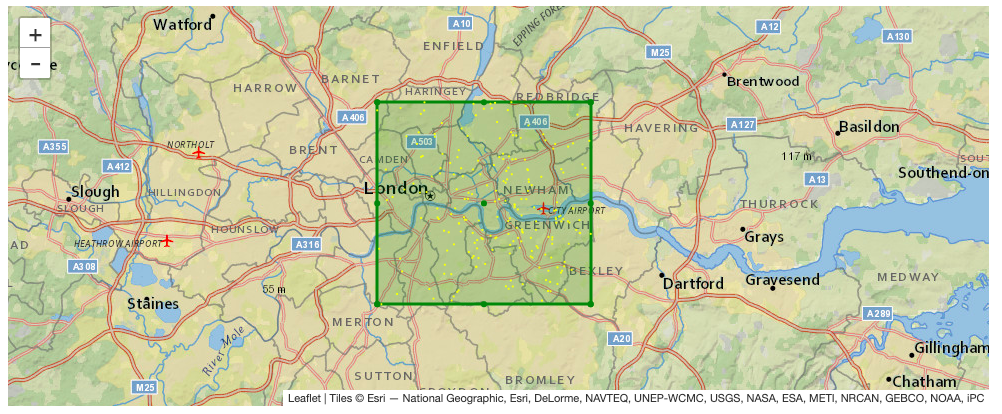

In [149]:
bin_num = 4
bins_london = np.zeros(bin_num)
bins_london[0] = len(new_data.loc[new_data['x'] < xs[1]].loc[new_data['y'] < ys[1]].index)
bins_london[1] = len(new_data.loc[new_data['x'] >= xs[1]].loc[new_data['y'] < ys[1]].index) 
bins_london[2] = len(new_data.loc[new_data['x'] < xs[1]].loc[new_data['y'] >= ys[1]].index)
bins_london[3] = len(new_data.loc[new_data['x'] >= xs[1]].loc[new_data['y'] >= ys[1]].index)
bombs = len(new_data.index)

Из хи-квадрат критерия Пирсона:
    
$n_i = bins[i]$
    
$E_i = n \cdot p_i = \dfrac{219}{4}$
    

$\chi^2 = \sum_{i=1}^{4}\dfrac{(n_i - E_i)^2}{E_i} \sim \chi^2_{3}$

In [150]:
e = bombs / bin_num
chi2 = ((bins_london - e)**2).sum() / e
print(chi2)
print(scipy.stats.chi2.interval(alpha=1-alpha, df=3))

14.515981735159817
(0.21579528262389797, 9.348403604496148)


Видим, что наша статистика больше правого конца, значит $H_0$ отвергается

## 3.2

Чтобы найти ошибку первого рода для нашего критерия, будем генерить 219 точек из двумерного равнометрого распределения
$U[min_x, max_x][min_y, max_y]$ и считать количество отклоненных нулевых гипотез.

In [151]:
def check_bins(data, x, y):
    left = data[np.where(data[:, 0] < x)]
    right = data[np.where(data[:, 0] >= x)]
    bot_left = left[np.where(left[:, 1] < y)]
    bot_right = right[np.where(right[:, 1] < y)]
    top_left = left[np.where(left[:, 1] >= y)]
    top_right = right[np.where(right[:, 1] >= y)]
    return np.array([len(bot_left), len(bot_right), len(top_left), len(top_right)])

In [122]:
xy_min = [min_x, min_y]
xy_max = [max_x, max_y]
alphas = 0
left, right = scipy.stats.chi2.interval(alpha=1-alpha, df=3)
montecarlo_num = 10000
for i in range(montecarlo_num):
    data = np.random.uniform(low=xy_min, high=xy_max, size=(bombs,2))
    bins = check_bins(data, xs[1], ys[1])
    chi2 = ((bins - e)**2).sum() / e
    alphas += (chi2 > right or chi2 < left)
print("Уровень значимости:", alphas / montecarlo_num)

Уровень значимости: 0.0499


# 3.3

Рассмотрим распределение $[Beta(x; 1 + \varepsilon, 1 + \varepsilon) \times Beta(y; 1 + \varepsilon,  1 + \varepsilon)]$

$\varepsilon \in [-1, 2]$ с шагом 0.1 в качестве альтернативной гипотезы.

Постройте империческую ошибку 2-го рода

Так как $Beta(1 + \varepsilon, 1 + \varepsilon) \in [0, 1]$, придется сжимать и двигать бомбы (на самом деле не придется, ведь мы только считаем кол-во бомб в бине, но теперь мы атакуем кусочек на Экваторе)

Для применения хи-квадрат критерия:

$E_i = n \cdot p_i$
    

$\chi^2 = \sum_{i=1}^{4}\dfrac{(n_i - E_i)^2}{E_i} \sim \chi^2_{3}$

нужно посчитать $E_i$, его я буду считать численно с помощью метода Монте-Карло

 Резать для Beta будем по 0.5, так как ожидание бета распределения $\dfrac{\alpha}{\alpha + \beta} = \dfrac{1 + \varepsilon}{1 + \varepsilon + 1 + \varepsilon} = 0.5$ 

In [192]:
eps = np.arange(-0.9, 2, 0.1)

montecarlo_n = 1000

for k in tqdm_notebook(range(len(eps))):
    e = eps[k]
    mbetas = 0
    for i in range(montecarlo_n):
        bins = np.zeros(4)
        for j in range(50): #находим ожидание
            x = scipy.stats.beta.rvs(1 + e, 1 + e, size=bombs).reshape((bombs, 1))
            y = scipy.stats.beta.rvs(1 + e, 1 + e, size=bombs).reshape((bombs, 1))
            data = np.hstack((x, y))
            bins += check_bins(data, 0.5, 0.5)
        bins /= 100
        chi2 = (((bins_london - bins)**2) / bins).sum() 
        mbetas += (chi2 > right or chi2 < left) 
    print("Мощность при eps={:.2f}: {}".format(e, mbetas / montecarlo_n) )


Мощность при eps=-0.90: 1.0
Мощность при eps=-0.80: 1.0
Мощность при eps=-0.70: 1.0
Мощность при eps=-0.60: 1.0
Мощность при eps=-0.50: 1.0
Мощность при eps=-0.40: 1.0
Мощность при eps=-0.30: 1.0
Мощность при eps=-0.20: 1.0
Мощность при eps=-0.10: 1.0
Мощность при eps=-0.00: 1.0
Мощность при eps=0.10: 1.0
Мощность при eps=0.20: 1.0
Мощность при eps=0.30: 1.0
Мощность при eps=0.40: 1.0
Мощность при eps=0.50: 1.0
Мощность при eps=0.60: 1.0
Мощность при eps=0.70: 1.0
Мощность при eps=0.80: 1.0
Мощность при eps=0.90: 1.0
Мощность при eps=1.00: 1.0
Мощность при eps=1.10: 1.0
Мощность при eps=1.20: 1.0
Мощность при eps=1.30: 1.0
Мощность при eps=1.40: 1.0
Мощность при eps=1.50: 1.0
Мощность при eps=1.60: 1.0
Мощность при eps=1.70: 1.0
Мощность при eps=1.80: 1.0
Мощность при eps=1.90: 1.0


Получается, что распределение бомб, действительно неравномерное (наш критерий хорошо работает для равномерного распределения и имперический уровень значимости совпадает с заданным)
При этом гипотеза о beta распределении всегда отвергается, значит бобмы раскиданы и не по бета распределению

# 4

На острове с бесконечным населением живет племя туземцев. $\pi = \dfrac{n}{N}$, где n количество людей с I группой крови в выборке, N общее количество людей в выборке. 
Наша гипотеза $H_0: \pi = \pi_0$

Хотим найти $min \ N : p(\pi \in [\pi_0 - \Delta; \pi_0 + \Delta]) \geqslant q \ | \ H_0$ где $\Delta = 0.02, q = 0.95$

$p(\pi \in [\pi_0 - \Delta; \pi_0 + \Delta]) = p(n \in [N \cdot(\pi_0 - \Delta); N(\pi_0 + \Delta)]) $

$p(n \in [N \cdot(\pi_0 - \Delta); N(\pi_0 + \Delta)]) = p(n <N(\pi_0 + \Delta)) - p(n < N(\pi_0 - \Delta)) $

При верной $H_0$ получаем биноминальное распределение, с вероятностью успеха $\pi_0$, n количество успехов

$$p(n < N(\pi_0 - \Delta)) = \sum_{k=0}^{\lceil N(\pi_0 - \Delta) \rceil - 1} C^k_N \pi_0^k (1-\pi_0)^{N - k}$$

$$p(n < N(\pi_0 + \Delta)) = \sum_{k=0}^{\lceil N(\pi_0 + \Delta) \rceil - 1} C^k_N \pi_0^k (1-\pi_0)^{N - k}$$

$$p(n \in [N \cdot(\pi_0 - \Delta); N(\pi_0 + \Delta)]) = \sum_{k=0}^{\lceil N(\pi_0 + \Delta) \rceil - 1} C^k_N \pi_0^k (1-\pi_0)^{N - k} - \sum_{k=0}^{\lceil N(\pi_0 - \Delta) \rceil - 1} C^k_N \pi_0^k (1-\pi_0)^{N - k} = 
\sum_{k=\lceil N(\pi_0 - \Delta) \rceil}^{\lceil N(\pi_0 + \Delta) \rceil - 1} C^k_N \pi_0^k (1-\pi_0)^{N - k}$$

In [195]:
from math import ceil

delta = 0.02
q = 0.95

def count_sum(st, fin, pi0, N):
    res = 0
    p = pi0 ** st
    np = (1 - pi0) ** (N - st)
    for k in range(st, fin):
        res += p * np * scipy.special.binom(N, k)
        p *= pi0
        np /= (1 - pi0)
    return res

def find_n(pi0):
    N = 1
    while 42:
        st, fin = ceil(N * (pi0 - delta)), ceil(N * (pi0 + delta))
        if count_sum(st, fin, pi0, N) >= q:
            print('Минимальное количество людей в выборке при pi0={}: {}'.format(pi0, N))
            return
        N += 1
        
for p0 in [0.1, 0.3, 0.5, 0.9, 0.95, 0.99]:
    find_n(p0)


Минимальное количество людей в выборке при pi0=0.1: 825
Минимальное количество людей в выборке при pi0=0.3: 1139
Минимальное количество людей в выборке при pi0=0.5: 1030
Минимальное количество людей в выборке при pi0=0.9: 834
Минимальное количество людей в выборке при pi0=0.95: 429
Минимальное количество людей в выборке при pi0=0.99: 1


В целом, кажется этого решения достаточно, но рас уж в бонусе тоже похожие задачи, можно попробовать привести к аналитическому решению:

$$P\left(\pi_0 - \Delta <\dfrac{n}{N} < \pi_0 + \Delta \right) = P\left(\left|\dfrac{n}{N} - \pi_0 \right| < \Delta \right) =  P\left(\left|\dfrac{n - N\pi_0}{N} \right| < \Delta\right) =  P\left(\left|\dfrac{n - N\pi_0}{\sqrt{N\pi_0(1-\pi_0)}} \right| < \dfrac{\Delta \sqrt{N}}{\sqrt{\pi_0(1 - \pi_0)}}\right) = 2\Phi\left(\dfrac{\Delta \sqrt{N}}{\sqrt{\pi_0(1 - \pi_0)}}\right)$$, где $\Phi(x) = \int_{0}^x \dfrac{1}{\sqrt2\pi} e^{-\frac{t^2}{2}}dt$ функция Лапласа (2Ф, так как хотим учесть еще отрицательную половинку)


$$2\Phi\left(\dfrac{\Delta \sqrt{N}}{\sqrt{\pi_0(1 - \pi_0)}}\right) \geqslant 0.95 $$

$$\Phi\left(\dfrac{\Delta \sqrt{N}}{\sqrt{\pi_0(1 - \pi_0)}}\right)\geqslant 0.475 = \Phi(1.96) $$ 

$$ \dfrac{\Delta \sqrt{N}}{\sqrt{\pi_0(1 - \pi_0)}} \geqslant 1.96 $$


$$N \geqslant \dfrac{2.996 \cdot \pi_0(1 - \pi_0) }{\Delta^2} = \pi_0 (1 - \pi_0) \cdot 9603 $$ (вычисления ниже)


In [4]:
left, right = scipy.stats.norm.interval(0.95)
print(right)
print(right**2 / 0.02**2)

1.959963984540054
9603.647051735314


Пусть n величина выборки, у которой мы проверяем группу крови. 

Количество людей с первой группой f = $\sum_{i=1}^S I_{[x_i = 1]}$

При верной $H_0: E \dfrac{f}{n} = P$

Из подсказки 1) $Var(p) = E (p - P)^2 = \dfrac{P(1-P)}{n} \dfrac{(N - n)}{(N-1)}$

Тогда по ЦПТ:


$$\dfrac{\frac{k}{n} - P}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}}  \to \mathcal{N}(0, 1)$$


$$P\left(\left|\dfrac{k}{n} - P \right| < \Delta \right) = P\left(\left|  \dfrac{\frac{k}{n} - P}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right| < \dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) = \Phi\left(\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) - \Phi\left(-\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) = 2\Phi\left(\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) - 1 \geqslant 0.95$$ [где $\Phi$ функция стандартного нормального распределения]

$$2\Phi\left(\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) \geqslant 1.95$$

$$\Phi\left(\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) \geqslant 0.975$$

In [7]:
# Ф(0) = 0.5, значит нам нужно, чтобы справа от 0 было 0.475, найдем такое значение Ф
left, right = scipy.stats.norm.interval(0.475)
print(right)

0.6356570136975828


$$\Phi\left(\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \right) \geqslant \Phi(0.635657)$$

$$\dfrac{\Delta}{\sqrt{\frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}}} \geqslant 0.635657 = q$$


$$\dfrac{\Delta^2}{q^2} \geqslant \frac{P(1-P)}{n} \frac{(N - n)}{(N-1)}$$

$$\dfrac{\Delta^2}{q^2} \dfrac{N - 1}{P(1 - P)} \geqslant \dfrac{N - n}{n} = \dfrac{N}{n} - 1$$

$$ n \geqslant \dfrac{N}{\frac{\Delta^2}{q^2} \frac{N - 1}{P(1 - P) + 1}}$$

$$ n = \left \lceil \dfrac{N}{\frac{\Delta^2}{q^2} \frac{N - 1}{P(1 - P) } + 1 } \right \rceil$$

In [10]:
delta = 0.02
print((delta ** 2 / right ** 2))

0.0009899523816265822


$$ n = \left \lceil \dfrac{N}{0.001 \frac{N - 1}{P(1 - P) } + 1 } \right \rceil$$